# BMI 예제를 통한 K-fold Cross Validation 구현

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv('data/bmi.csv', skiprows=3)
display(df) # label: 0(저체중), 1(정상), 2(과체중)

,label,height,weight
0,1,188,71
1,2,161,68
2,0,178,52
3,2,136,63
4,1,145,52
...,...,...,...
19995,0,163,48
19996,2,139,70
19997,1,150,48
19998,1,189,69


## 상관분석
종속변수(레이블)에 영향을 미치지 않는 feature(필드, 속성)을 제외
* 1: 상관관계 있음
* 0: 상관관계 없음

## Data Preprocessing

### 결측치 처리

In [33]:
# 결측치 확인
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   label   20000 non-null  int64
 1   height  20000 non-null  int64
 2   weight  20000 non-null  int64
dtypes: int64(3)
memory usage: 468.9 KB
None


### 이상치 처리

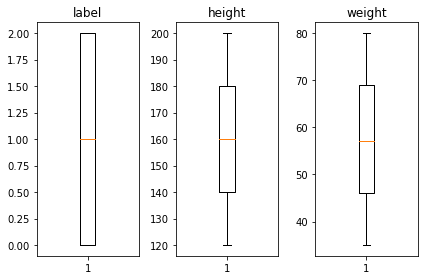

In [34]:
# 이상치 확인
fig = plt.figure()
fig_label = fig.add_subplot(1,3,1)
fig_height = fig.add_subplot(1,3,2)
fig_weight = fig.add_subplot(1,3,3)

fig_label.set_title('label')
fig_label.boxplot(df['label'])

fig_height.set_title('height')
fig_height.boxplot(df['height'])

fig_weight.set_title('weight')
fig_weight.boxplot(df['weight'])

fig.tight_layout()
plt.show()

### Data Split - Train Data, Test Data


In [3]:
x_train, x_test, t_train, t_test = \
train_test_split(df[['height', 'weight']], df['label'], 
                 test_size=0.3, random_state=0)

### 정규화

In [5]:
scaler_x = MinMaxScaler()

scaler_x.fit(x_train)
x_train_norm = scaler_x.transform(x_train)

scaler_x.fit(x_test)
x_test_norm = scaler_x.transform(x_test)

print(x_train_norm)

# 안쓰는 변수 삭제
del x_train
del x_test

[[0.9375     0.8       ]
 [0.         0.86666667]
 [0.0125     0.57777778]
 ...
 [0.325      0.97777778]
 [0.6875     0.73333333]
 [0.75       0.48888889]]


### One-hot Encoding

In [6]:
sess = tf.Session()
t_train_onehot = sess.run(tf.one_hot(t_train, depth=3))
t_test_onehot = sess.run(tf.one_hot(t_test, depth=3))

# 안쓰는 변수 삭제
del t_train
del t_test

print(t_train_onehot)

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


## Softmax Regression
### tensorflow node 생성

In [7]:
# X, T
X = tf.placeholder(shape=[None,2], dtype=tf.float32)
T = tf.placeholder(shape=[None,3], dtype=tf.float32)

# W, b
W = tf.Variable(tf.random.normal([2,3]), name='weight')
b = tf.Variable(tf.random.normal([3]), name='bias')

# Hypothesis
logit = tf.matmul(X, W) + b
H = tf.nn.softmax(logit)

# log loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit, labels=T))

# gradient descent algorithm
train = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)

### 배치 처리

In [8]:
# parameter
num_of_epoch = 1000
batch_size = 100

### 학습용 함수
* K-fold Cross Validation 진행 시, 실행할 함수
* 학습에 필요한 3가지 인자: 세션 객체, 학습용 x_data, 학습용 t_data

In [9]:
def run_train(sess, train_x, train_t):
    print('=====START LEARNING=====')
    
    # 초기화
    sess.run(tf.global_variables_initializer())
    
    # 반복학습
    for step in range(num_of_epoch):
        # 1 epoch: 입력 데이터(train_x)를 100개씩 잘라서 총 140번 학습
        total_batch = int(train_x.shape[0] / batch_size) # shape: (14000, 2)
        
        for i in range(total_batch):
            # 100개씩: 0~99, 100~199, ...
            batch_x = train_x[i*batch_size:(i+1)*batch_size] 
            batch_t = train_t[i*batch_size:(i+1)*batch_size]
            _, loss_val = sess.run([train, loss], feed_dict={X: batch_x, T: batch_t})
            
        if step % 100 == 0:
            print('Loss: {}'.format(loss_val))
    
    print('=====FINISH LEARNING=====')

## Accuracy
* Ture를 True로 맞추고, False를 False로 맞춘 비율
* `tf.argmax()`: 현재 가지고 있는 numpy array 중 가장 큰 값의 인덱스를 알려줌

In [10]:
predict = tf.argmax(H, 1) # axis=1: 열방향으로 비교
correct = tf.equal(predict, tf.argmax(T, 1)) # True or False?
accuracy = tf.reduce_mean(tf.cast(correct, dtype=tf.float32)) # cast: 1 or 0

# learning
run_train(sess, x_train_norm, t_train_onehot)

# Training Data Set을 이용하여 성능평가 (X)
result = sess.run(accuracy, feed_dict={X: x_train_norm, T: t_train_onehot})

print('Accuracy : {}'.format(result))

=====START LEARNING=====
Loss: 1.0097393989562988
Loss: 0.205830380320549
Loss: 0.16252490878105164
Loss: 0.14284533262252808
Loss: 0.13104629516601562
Loss: 0.12297458946704865
Loss: 0.11700376868247986
Loss: 0.11235222220420837
Loss: 0.10859201103448868
Loss: 0.10546697676181793
=====FINISH LEARNING=====
Accuracy : 0.9827142953872681


## K-fold Cross Validation
전체 데이터 양이 적은 경우, 학습 모델에 대한 성능 평가 방법

In [11]:
# 총 5번의 학습과 5번의 평가가 이뤄짐
# 시간이 5배가 걸리지만 더 정확한 성능평가가 이뤄짐
# 우리가 만든 모델이 잘 만들어졌는 지 확인하는 용도
cv = 5      
results = [] 

# Split Train Data and Validation Data
kf = KFold(n_splits=cv, shuffle=True) 

# cv만큼 Train Data가 잘림 -> 한 폴드에 대해 train용 데이터의 인덱스, test용 데이터의 인덱스 뽑힘
for training_idx, validation_idx in kf.split(x_train_norm): # x_train_norm: Kfold로 나누어진 row 인덱스값이 나옴
    
    training_x = x_train_norm[training_idx] # Fancy Indexing
    training_t = t_train_onehot[training_idx]
    
    validation_x = x_train_norm[validation_idx]
    validation_t = t_train_onehot[validation_idx]
    
    # 1. training data로 learning
    run_train(sess, training_x, training_t)
    
    # 2. testing data로 validation: #1에서 만든 학습모델에 대한 정확도(성능평가) 측정
    results.append(sess.run(accuracy, feed_dict={X:validation_x, T: validation_t}))
    
print('측정한 각 Fold의 정확도: {}'.format(results))

# 3. results 안 각각의 학습 결과에 대한 평가값(정확도)의 평균
final_acc = np.mean(results)
print('K-Fold Validation을 통한 우리 모델의 최종 Accuracy: {}'.format(final_acc))

=====START LEARNING=====
Loss: 0.8705247640609741
Loss: 0.1947106122970581
Loss: 0.14953257143497467
Loss: 0.12870106101036072
Loss: 0.11614877730607986
Loss: 0.10755503922700882
Loss: 0.1012067049741745
Loss: 0.09627267718315125
Loss: 0.09229623526334763
Loss: 0.08900299668312073
=====FINISH LEARNING=====
=====START LEARNING=====
Loss: 0.9283795952796936
Loss: 0.20817093551158905
Loss: 0.16001951694488525
Loss: 0.13791251182556152
Loss: 0.1246616393327713
Loss: 0.11563077569007874
Loss: 0.10898330062627792
Loss: 0.10383119434118271
Loss: 0.09968775510787964
Loss: 0.09626123309135437
=====FINISH LEARNING=====
=====START LEARNING=====
Loss: 0.9251052737236023
Loss: 0.21578991413116455
Loss: 0.16912303864955902
Loss: 0.14765846729278564
Loss: 0.13476821780204773
Loss: 0.12596982717514038
Loss: 0.11948574334383011
Loss: 0.11445555835962296
Loss: 0.11040762811899185
Loss: 0.10705868899822235
=====FINISH LEARNING=====
=====START LEARNING=====
Loss: 0.9100033044815063
Loss: 0.211562290787696

## Testing

In [12]:
run_train(sess, training_x, training_t)
final_accuracy = sess.run(accuracy, feed_dict={X: x_test_norm, T: t_test_onehot})
print('우리 모델의 최종 정확도: {}'.format(final_accuracy))

=====START LEARNING=====
Loss: 0.9455364942550659
Loss: 0.20482388138771057
Loss: 0.15653131902217865
Loss: 0.13469655811786652
Loss: 0.12171604484319687
Loss: 0.11291545629501343
Loss: 0.10646199434995651
Loss: 0.101473867893219
Loss: 0.0974717065691948
Loss: 0.09416808933019638
=====FINISH LEARNING=====
우리 모델의 최종 정확도: 0.9836666584014893
